<a href="https://colab.research.google.com/github/KhawajaMuddassar/object_detection-and-image-classification/blob/main/training_sdd_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Single Shot Detector (SSD):**



The Single Shot Detector (SSD) is an object detection algorithm that processes images in a single pass to identify and locate multiple objects. Unlike traditional methods that use region proposal networks and multiple stages for detection, SSD integrates the detection pipeline into one unified network. It employs a base convolutional neural network (CNN) for feature extraction and utilizes a series of convolutional layers to predict bounding boxes and class scores directly from feature maps.

Different layers in a convolutional neural network possess varying receptive fields with respect to the original image. For instance, the initial layers feature smaller receptive fields, whereas the later layers exhibit larger receptive fields. In this context, we will explore how the Single Shot Detector (SSD) utilizes this characteristic to generate predictions for bounding boxes in images.

The Single Shot Detector (SSD) addresses the challenge of detecting objects at various scales through the following approaches:

* We utilize the pre-trained VGG network and enhance it by adding several layers until we achieve a 1x1 convolutional block.
* Rather than relying solely on the final layer for bounding box and class predictions, we incorporate predictions from multiple preceding layers.
* Instead of using anchor boxes, we introduce default boxes characterized by specific scales and aspect ratios.
* Each default box is designed to predict both the class of the object and the bounding box offsets, similar to the functionality of anchor boxes in the YOLO framework.

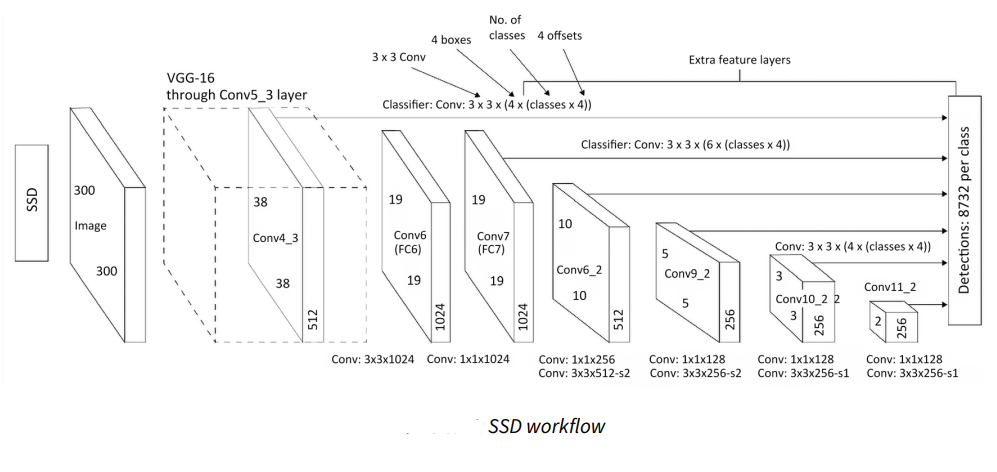

As illustrated in the preceding diagram, we process an image of size 300 x 300 x 3 through a pre-trained VGG-16 network to obtain the output from the conv5_3 layer. Additionally, we enhance the network by adding several convolutional layers following the conv5_3 output. From this configuration, we derive bounding box offsets and class predictions for each cell and each default box. The total number of predictions generated from the conv5_3 output is 38 x 38 x 4, where 38 x 38 represents the output dimensions of the conv5_3 layer and 4 denotes the number of default boxes associated with it. Likewise, we will detail the total number of detections produced throughout the network.


**Scales and Aspect Ratios of default boxes:**

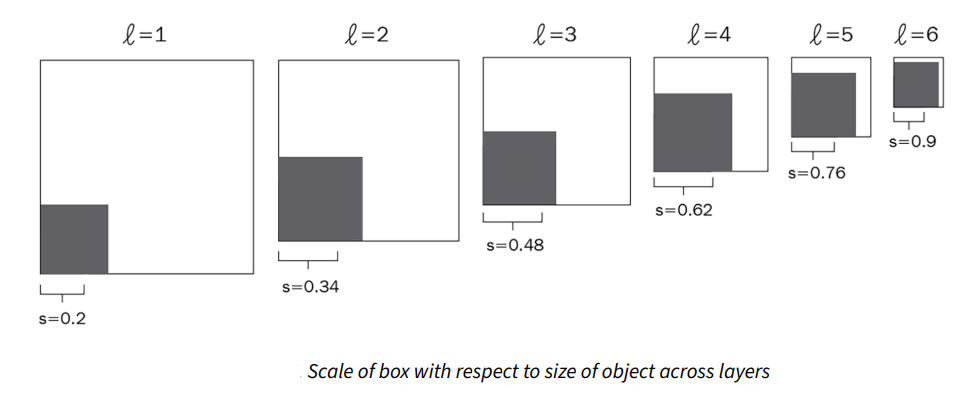
Consider above scenario in which the minimum scale of an object is defined as 20% of the height and 20% of the width of the image, while the maximum scale is 90% of the height and 90% of the width. In this context, we gradually increase the scale across the network layers, recognizing that as we advance toward the later layers, the size of the image diminishes significantly.

**Gradual scaling of the image:**

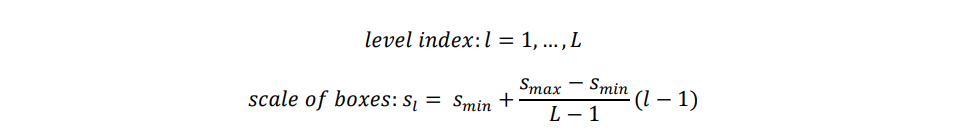

**Boxes of different aspect ratios:**

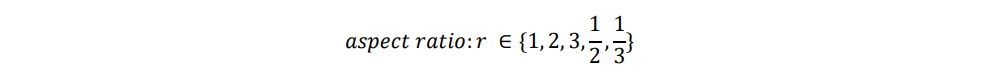

**The centers of the box for different layers:**

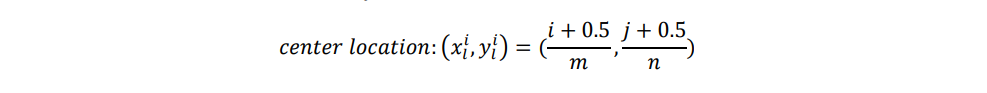

Here, i and j together represent a cell in layer l. On the other hand, the width and height corresponding to different aspect ratios are calculated as follows:
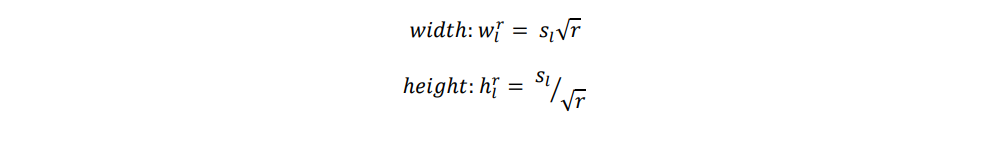

**Additional Scaling:**

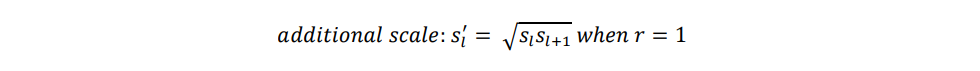


**optimizing loss values:**
* **Classification loss:**

In the below equation, pos represents the few default boxes that have a high overlap with the ground truth, while neg represents the misclassified boxes that were predicting a class but in fact did not contain an object. Finally, we ensure that the pos:neg ratio is at most 1:3, as if we do not perform this sampling, we would have a dominance of background class boxes.
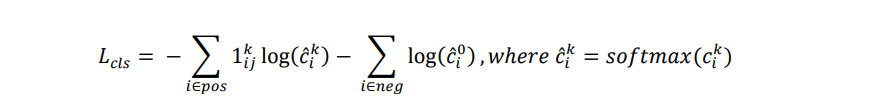
* **Localization loss:** palce image
For localization, we consider the loss values only when the objectness score
is greater than a certain threshold.The localization loss is calculated as follows:
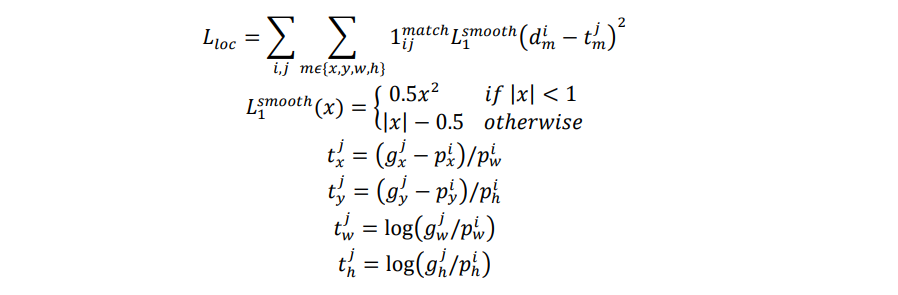

[in-depth SSD workflow](https://arxiv.org/abs/1512.02325)



# **Implementing SDD on custom Dataset**

Dataset URL: https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz 

Please enter the download URL: https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz
Data already downloaded and exists.
Data processing completed.
Number of classes: 3
Background class index: 0


[10/31/24 08:32:51] INFO     15225 items loaded                                                                                   ]8;id=713317;file://<ipython-input-4-deb872f77981>:70\<ipython-input-4-deb872f77981>]8;;\:]8;id=701458;file://<ipython-input-4-deb872f77981>:70#__init__:70\__init__:70]8;;\

                    INFO     15225 items loaded                                                                                   ]8;id=511087;file://<ipython-input-4-deb872f77981>:70\<ipython-input-4-deb872f77981>]8;;\:]8;id=976486;file://<ipython-input-4-deb872f77981>:70#__init__:70\__init__:70]8;;\

                    INFO     15225 items loaded                                                                                   ]8;id=582059;file://<ipython-input-4-deb872f77981>:70\<ipython-input-4-deb872f77981>]8;;\:]8;id=812049;file://<ipython-input-4-deb872f77981>:70#__init__:70\__init__:70]8;;\

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Loaded base model.



/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


EPOCH: 3.000  val_loss: 1.199  (3569.11s - 0.00s remaining)[[17, 89, 106, 137]] ['Truck @ 1.00']


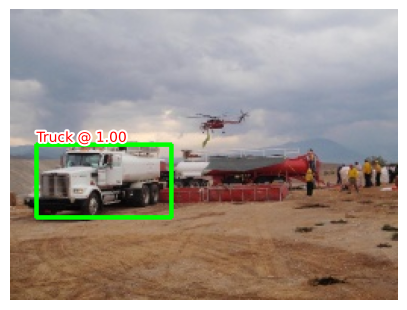

[[71, 20, 229, 130], [-2, 59, 69, 91]] ['Bus @ 1.00', 'Bus @ 0.98']


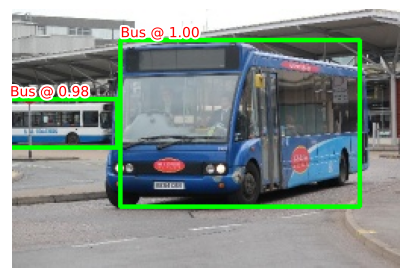

[[10, 34, 243, 153]] ['Bus @ 1.00']


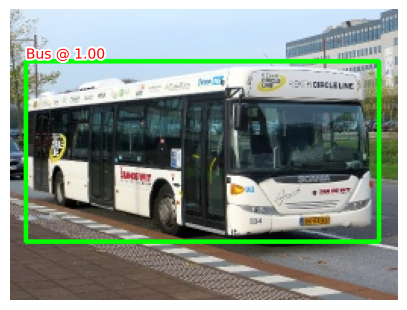

In [ ]:
%pip install -q torch_snippets
import os, torch, pandas as pd, collections, glob, numpy as np, sys
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch_snippets import *
from torch_snippets.logger import logger
from torch_snippets.torch_loader import Report, DataLoader
from torch_snippets import show
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Downloader Class
class DataDownloader:

    def __init__(self, url):
        self.url = url
        self.data_dir = '../open-images-bus-trucks'
    def download_and_extract(self):
        if not os.path.exists(self.data_dir):
            self._download_file()
            self._extract_file()
            self._cleanup()
            self._clone_repository()
            print("Download and extraction completed.")
        else:
            print("Data already downloaded and exists.")
    def _download_file(self):
        os.system(f'wget --quiet {self.url}')
    def _extract_file(self):
        os.system('tar -xf open-images-bus-trucks.tar.xz')
    def _cleanup(self):
        os.system('rm open-images-bus-trucks.tar.xz')
    def _clone_repository(self):
        os.system('git clone https://github.com/KhawajaMuddassar/ssd-utils/')
        os.chdir('ssd-utils')

# Data Preprocessing class
class PreprocessDownloadedData():
    def __init__(self, data_root='../open-images-bus-trucks/'):
        self.data_root = data_root
        self.image_root = f'{self.data_root}/images'
        self.df_raw  = pd.read_csv(os.path.join(self.data_root, 'df.csv'))
        self.df= self.df_raw[self.df_raw['ImageID'].isin(self.df_raw['ImageID'].unique().tolist())]
        self.label2target, self.target2label, self.background_class, self.num_classes = self.process_labels()

    def process_labels(self):
        #Create mappings for labels and targets
        df = self.df
        label2target = {label: idx + 1 for idx, label in enumerate(self.df_raw['LabelName'].unique())}
        label2target['background'] = 0
        target2label = {idx: label for label, idx in label2target.items()}
        background_class = label2target['background']
        num_classes = len(label2target)
        return label2target, target2label, background_class, num_classes

# Dataset Class
class OpenDataset(Dataset,PreprocessDownloadedData):
    w, h = 300, 300
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    denormalize = transforms.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                                       std=[1 / 0.229, 1 / 0.224, 1 / 0.225])

    def __init__(self,pre_processor: PreprocessDownloadedData):
        super().__init__()
        self.df = self.df
        self.label2target = self.label2target
        self.image_dir = self.image_root
        self.files = glob.glob(os.path.join(self.image_dir, '*'))
        self.image_infos = self.df['ImageID'].unique()
        logger.info(f'{len(self)} items loaded')

    def __len__(self):
        return len(self.image_infos)

    def preprocess_image(self, img):
        img = torch.tensor(img).permute(2, 0, 1)
        return self.normalize(img).to(device).float()

    def __getitem__(self, ix):
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR)) / 255.0
        data = self.df[self.df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        boxes = data[['XMin', 'YMin', 'XMax', 'YMax']].values
        boxes[:, [0, 2]] *= self.w
        boxes[:, [1, 3]] *= self.h
        boxes = boxes.astype(np.uint32).tolist()  # Convert to absolute coordinates
        return img, boxes, labels

    def collate_fn(self, batch):
        images, boxes, labels = [], [], []
        for item in batch:
            img, image_boxes, image_labels = item
            img = self.preprocess_image(img).unsqueeze(0)
            images.append(img)
            boxes.append(torch.tensor(image_boxes).float().to(device) / 300.0)
            labels.append(torch.tensor([self.label2target[c] for c in image_labels]).long().to(device))
        return torch.cat(images).to(device), boxes, labels

# Train Test Split
class DatasetSplitter:
    def __init__(self, dataframe,test_size=0.1, random_state=99, batch_size=4):
        from sklearn.model_selection import train_test_split
        from torch.utils.data import DataLoader

        self.train_test_split = train_test_split
        self.DataLoader = DataLoader
        self.dataframe = dataframe
        self.test_size = test_size
        self.random_state = random_state
        self.batch_size = batch_size
        self.train_loader = None
        self.test_loader = None
    def split_data(self):
        trn_ids, val_ids = self.train_test_split(
            self.dataframe.ImageID.unique(),
            test_size=self.test_size,
            random_state=self.random_state)
        trn_df = self.dataframe[self.dataframe['ImageID'].isin(trn_ids)]
        val_df = self.dataframe[self.dataframe['ImageID'].isin(val_ids)]
        return trn_df, val_df
    def create_dataloaders(self):
        trn_df, val_df = self.split_data()
        train_ds = OpenDataset(trn_df)
        test_ds = OpenDataset(val_df)
        train_loader = self.train_loader
        test_loader = self.test_loader
        train_loader = self.DataLoader(train_ds, batch_size=self.batch_size,
                                        collate_fn=train_ds.collate_fn, drop_last=True)
        test_loader = self.DataLoader(test_ds, batch_size=self.batch_size,
                                        collate_fn=test_ds.collate_fn, drop_last=True)
        return train_loader, test_loader, test_ds, train_ds

# Train Model
class ModelTrainer:
    def __init__(self, num_classes, device, learning_rate=1e-4, weight_decay=1e-5):
        sys.path.append(os.path.join(os.getcwd(), '../ssd-utils'))
        from model import SSD300, MultiBoxLoss
        from detect import detect
        # Initialize the model, optimizer, and criterion
        self.model = SSD300(num_classes, device)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.criterion = MultiBoxLoss(priors_cxcy=self.model.priors_cxcy, device=device)
    def train_batch(self, inputs):
        self.model.train()
        images, boxes, labels = inputs
        _regr, _clss = self.model(images)
        loss = self.criterion(_regr, _clss, boxes, labels)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss

    @torch.no_grad()
    def validate_batch(self, inputs):
        self.model.eval()
        images, boxes, labels = inputs
        _regr, _clss = self.model(images)
        loss = self.criterion(_regr, _clss, boxes, labels)
        return loss
    def fit(self, train_loader, test_loader, n_epochs, log):
        logs_to_print = 5
        for epoch in range(n_epochs):
            _n = len(train_loader)
            for ix, inputs in enumerate(train_loader):
                loss = self.train_batch(inputs)
                pos = (epoch + (ix + 1) / _n)
                log.record(pos, trn_loss=loss.item(), end='\r')
            _n = len(test_loader)
            for ix, inputs in enumerate(test_loader):
                loss = self.validate_batch(inputs)
                pos = (epoch + (ix + 1) / _n)
                log.record(pos, val_loss=loss.item(), end='\r')
    def get_model(self):
        return self.model

# Main
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('Dataset URL: https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz','\n')
    download_url = input("Please enter the download URL: ")

    # Download Dataset
    downloader = DataDownloader(download_url)
    downloader.download_and_extract()

    # Preprocess Dataset
    pre_processor = PreprocessDownloadedData()
    print("Data processing completed.")
    print(f"Number of classes: {pre_processor.num_classes}")
    print(f"Background class index: {pre_processor.background_class}")

    # Initialize dataset
    dataset = OpenDataset(pre_processor)

    # Training, test datasets and dataloader
    splitter = DatasetSplitter(dataset.df)
    train_loader, test_loader,test_ds,train_ds = splitter.create_dataloaders()

    # Train Model
    n_epochs = 3
    log = Report(n_epochs=n_epochs)
    trainer = ModelTrainer(num_classes=pre_processor.num_classes, device=device)
    trainer.fit(train_loader, test_loader, n_epochs, log)
    model = trainer.get_model()

    # Make Prediciotn on Unseen Images
    image_paths =  glob.glob(f'/content/open-images-bus-trucks/images/*')
    from torch_snippets.loader import choose
    from torch_snippets.paths import find
    image_id = choose(test_ds.image_infos)
    img_path = find(image_id, test_ds.files)
    original_image = Image.open(img_path, mode='r')
    original_image = original_image.convert('RGB')

    sys.path.append(os.path.join(os.getcwd(), '../ssd-utils'))
    from detect import detect
    from torch_snippets import *
    image_paths = glob.glob(f'/content/open-images-bus-trucks/images/*')
    for _ in range(3):
        image_id = choose(test_ds.image_infos)
        img_path = find(image_id, test_ds.files)
        original_image = Image.open(img_path, mode='r')
        bbs, labels, scores = detect(original_image, model, min_score=0.9, max_overlap=0.5,top_k=200, device=device)
        labels = [pre_processor.target2label[c.item()] for c in labels]
        label_with_conf = [f'{l} @ {s:.2f}' for l,s in zip(labels,scores)]
        print(bbs, label_with_conf)
        show(original_image, bbs=bbs, texts=label_with_conf, text_sz=10 )
